# Project : Machine Learning For Trading And Portfolio Management

`Nicolas Walpoel`

In [80]:
from IPython.display import Image
import pandas as pd
import numpy as np
from IPython.utils import io
import matplotlib.pyplot as plt

# 1 - Introduction

The Effective Federal Funds Rate (EFFR) is a cornerstone of the global financial system, serving as the benchmark interest rate that influences a broad spectrum of financial instruments, including bonds, mortgages, and corporate loans. It represents the interest rate at which depository institutions lend balances to each other overnight, and it is actively steered by the Federal Reserve (FED) to achieve its monetary policy objectives. Through its control over the EFFR, the FED aims to stabilize inflation, foster employment, and ensure financial stability, making it a key driver of economic dynamics and market behavior. The critical role of the EFFR extends beyond monetary policy implementation. Changes in the EFFR have a profound impact on financial markets, particularly on interest-rate-sensitive assets such as U.S. Treasury bonds. Investors and traders closely monitor the EFFR and FED policy announcements to anticipate the trajectory of rates and align their strategies accordingly. This has led to a market environment where FED rate adjustments are often priced into asset values before they are officially implemented, making accurate forecasting of the EFFR a challenging but potentially rewarding endeavor. Predicting the EFFR poses several significant difficulties. First, the FED’s decisions are influenced by a complex interplay of macroeconomic indicators, including inflation data, employment figures, and consumer sentiment. These factors are interdependent and subject to sudden shifts, making it challenging to model the FED's decision-making process accurately. Second, financial markets are forward-looking and often incorporate anticipated rate changes into prices ahead of time, diminishing the immediate utility of short-term predictions. This makes it essential to develop models that not only predict the direction of FED policy but also account for market expectations and potential mispricings.

### I - Linear Regression approach
To begin with, we propose to take a quick look at the existing literature on this subject, allowing us to build on prior findings and enabling gains in both time and precision. First of all, as shown by Chuayaocong in “Simple Regression Model with Key Economic Indicators to Predict Fed Funds Rate in the United States.ipynb” (6), it is futile to rely on simple regression models for rate prediction. This 2023 analysis demonstrates that a linear regression model using historical data and key macroeconomic indicators to predict the FED rate level yields a predicted value of 8% for the theoretical interest rate. This theoretical rate is significantly higher than the real interest rates of 1.5% to 1.75% in that period. 

### II - The Taylor rule

A more advanced method of predicting interest rate levels involves using the Taylor Rule introduced by John Taylor in 1993:

$i = r^* + \pi + 0.5(\pi - \pi^*) + 0.5(y - y^*)$

where :

- $i$ : Nominal interest rate (target federal funds rate)
- $r^*$: Real neutral interest rate (long-term equilibrium interest rate, often assumed to be 2%)
- $\pi$: Current inflation rate
- $\pi^*$: Target inflation rate (usually 2% for the U.S. Fed)
- $y$: Real GDP (current output)
- $y^*$: Potential GDP (full employment output)

The Taylor Rule is a monetary policy guideline used to estimate the appropriate level of a central bank's interest rate, typically the federal funds rate in the U.S., based on economic conditions. It provides a systematic way to adjust interest rates in response to changes in inflation, economic output, and other key indicators. However, as demonstrated by Alper D. Karakas in `Reevaluating the Taylor Rule with Machine Learning (April 2021)` (9), the Taylor Rule indicator is not an effective predictor, particularly for dates after 2010, as illustrated in the following graph. The paper also concludes that re-estimating Taylor’s parameters using Ordinary Least Squares (OLS) does not yield significantly better accuracy than the original Taylor Rule.

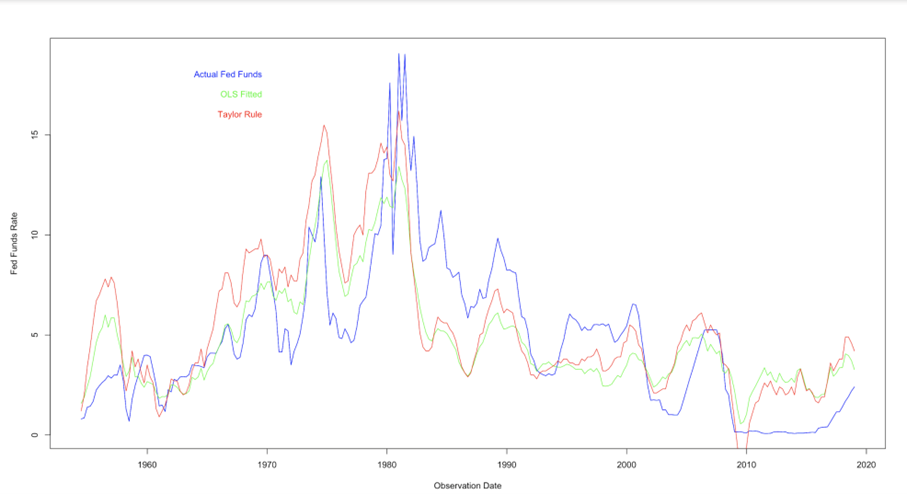

In [36]:
Image(filename='/Users/walpoel/Downloads/Taylor_Rule.png') 

Additionally, the Federal Reserve has introduced several indexes that are better suited for decision-making in the last two decades. These alternative rules are described in the paper `Policy Rules and How Policymakers Use Them` (5). We will use these results as a benchmark for validating our own machine learning-based approach.

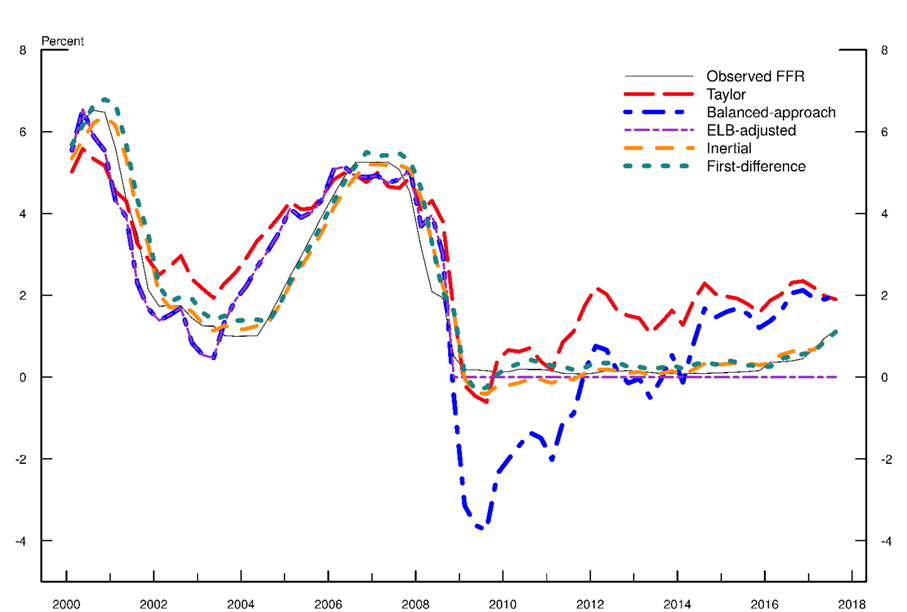

In [82]:
Image(filename='/Users/walpoel/Downloads/FED_Indexes.png') 

Machine learning (ML) has emerged as a promising approach to tackle the complexities of EFFR prediction. Unlike traditional econometric models such as ARIMAs or Taylor Rules, which often rely on linear assumptions and simplified relationships, ML models can capture nonlinear patterns and interactions among a wide range of macroeconomic variables. By leveraging a curated dataset of key macroeconomic indices, ML algorithms can identify subtle trends and insights that may elude conventional methods. Moreover, the flexibility of ML allows for the integration of alternative data sources, such as market sentiment and financial news, to enhance predictive accuracy.

### III - Market uncertainty

The objective of this project is to develop an efficient machine learning model to `forecast the sign of the Effective Federal Funds Rate change` and apply these predictions to design a trading strategy. As shown by some Fed watch indicators computed by CME group that tracks the probabilities of changes to the Fed rate (implied by 30-Day Fed Funds futures prices) (8), there is almost never a change of rate that is priced in the market with probability 1. For instance the September 18th, the market is quite uncertain about the FED decision 15 day prior to the meeting. To be more specific prior to the September 18th meeting, the Rate was at 5.5%, on Tuesday 3rd of the same month, the future market was anticipating a 38% chance of the next rate being at 5.25% and a 62% chance of being at 5% on the 18th.

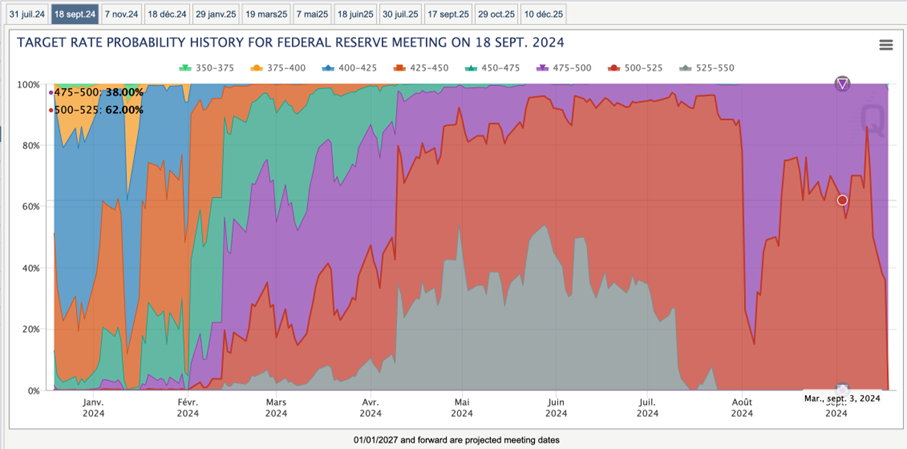

In [40]:
Image(filename='/Users/walpoel/Downloads/Fed_watch.png') 

Our strategy aims to exploit arbitrage opportunities created by those uncertaities by trading assets that are highly sensitive to rate changes, such as U.S. Treasury bonds. By accurately predicting the trajectory of the EFFR and understanding its market implications, the goal is to build a robust framework that bridges economic forecasting and trading strategy implementation. This project not only seeks to address the challenges of EFFR prediction but also explores the practical application of ML in navigating the intricate relationship between monetary policy and financial markets.

Our first approach uses a RandomForest model in order to capture the behavior of the EFFR and classify its evolution into three classes, the model while well fine-tuned, struggles to predict the rate changes even when taking into account class imbalance using SMOTE algorithms. We then decide to use a lgbm model specified in a ISCTE research article (7) that is trained with a bigger amount of data and is able to efficiently predict the EFFR. With those prediction and after showing that the EFFR is very closely related to the 13W US Treasuries rate, we compute arbitrage strategies with Sharpe ratios >1 that take positions in this asset following our predictions. Below in part 2, you will find a complete overview of our original dataset with a statistical analysis of key components, part 3 presents the model used and its parametrization, part 4 accounts for the backtests robustness checks of our first model as well as the computation of the second model alongside the implementation of the trading strategies and their backtests, finally part 5 concludes and part 6 contains all of our references and sources.

# 2 - Machin Learning Approach

Throughout my research, I came across a project that aligns with our goal of predicting the behavior of the Effective Federal Funds Rate (EFFR). This study furthers the scope by incorporating a wide range of explanatory variables using monthly data. It employs Machine Learning (ML) techniques, particularly focusing on LightGBM, to predict EFFR. 

### I - Overview for the main variables
The study utilized the FRED-MD macroeconomic dataset with 134 monthly U.S. economic indicators spanning from January 1960 to September 2024. The dataset was divided into training, validation, and testing sets in proportions of 80%, 10%, and 10%. Our focus is on creating forecast predictions for a trading strategy. Below, we introduce the key explanatory variables for the model:

1. TB3MSFFM (3-Month Treasury Bill Minus Effective Federal Funds Rate)
- Spread between the interest rate on 3-month U.S. Treasury bills and the Effective Federal Funds Rate (EFFR).
- Significance:
  - Reflects risk premiums and liquidity conditions in the short-term money market
  - A widening spread often signals market expectations of lower rates or heightened risk aversion
  - Captures market sentiment and potential arbitrage opportunities between the T-Bill market and the EFFR

2. GS1 (1-Year Treasury Constant Maturity Rate)
- The 1-year constant maturity Treasury rate is a benchmark interest rate for short-term government securities.
- Significance:
  - Reflects expectations of economic conditions over a 1-year horizon, including growth and inflation
  - Serves as a proxy for future monetary policy by reflecting both current Federal Reserve actions and market anticipations
  - Aligns the model with macro-level interest rate dynamics

3. COMPAPFFx (3-Month Commercial Paper Minus Federal Funds Rate)
- The spread between the 3-month AA-rated commercial paper rate and the Effective Federal Funds Rate.
- Significance:
  - Represents the credit risk premium and borrowing costs for corporations relative to interbank lending rates
  - An increase in this spread signals financial stress or tightening liquidity in corporate markets
  - Acts as a leading indicator for broader economic activity and financial conditions

The approach involves using data from the previous month to predict the Rates for the next month (refer to the `create_lagged_features` function).

### II - Choice of Modeling Technique
The LightGBM model demonstrated competitive performance, outperforming traditional benchmarks like ARIMA in terms of RMSE. However, deep learning models such as GRU and LSTM exhibited higher accuracy in specific scenarios. Our main concerns were being able to reproduct the work and we figured that light GBM, as well as Random Forests, handle quite well over-fitting problematics (since they use a subset of the data avaible to train each tree). 

Limitations and Future Work (as highlighted in the paper)
- Limited Observations: The dataset size imposes constraints on the generalizability of complex ML models
- Benchmarking: The lack of prior research on EFFR forecasting limits comparative analysis
- Dynamic Conditions: Changes in economic policy and external shocks could affect model applicability over time

### III - Conclusion
LightGBM stands out as a robust tool for EFFR forecasting, blending efficiency and interpretability. While advanced deep learning models may provide marginal accuracy improvements, LightGBM offers a balanced approach suitable for large-scale macroeconomic analyses. Future studies could integrate broader datasets and explore hybrid modeling techniques for enhanced performance. The models developed in this study are fine-tuned, with LightGBM chosen for its superior predictive capabilities over extended Taylor's rules. We propose to replicate this model and use it to develop a trading strategy.

# 3 - Modelisation

### I - LightGBM

LightGBM (Light Gradient Boosting Machine) is a cutting-edge machine learning algorithm designed to handle large-scale datasets efficiently and deliver high-performance predictions. It is particularly well-suited for problems where speed and scalability are critical, such as predicting changes in the effective Federal Funds Rate (EFFR). LightGBM is based on the gradient boosting framework, which builds models sequentially to minimize errors. However, it introduces several innovations, such as histogram-based computation, leaf-wise tree growth, and efficient handling of categorical features, making it faster and more accurate compared to traditional gradient boosting methods. Its ability to handle complex feature interactions, along with built-in support for feature importance evaluation, makes it an excellent choice for macroeconomic prediction tasks, where the relationships between features can be highly non-linear.

Foundational Algorithm: LightGBM

LightGBM builds on the principles of gradient boosting but incorporates enhancements that optimize both computational efficiency and predictive performance. The algorithm constructs decision trees sequentially, where each tree is trained to correct the residual errors of the previous trees. Below are the key components of LightGBM:

- Histogram-Based Computation

    LightGBM employs a histogram-based technique to accelerate the computation of split points. Features are bucketed into discrete bins (histograms) rather than being processed as continuous values. This approach significantly reduces memory usage and speeds up tree construction. For a feature $x$, it is discretized into $k$ bins, and the best split is determined by evaluating the gain for each bin.

- Leaf-Wise Tree Growth

    Unlike traditional boosting algorithms, which grow trees level-wise, LightGBM grows trees leaf-wise. This means that LightGBM selects the leaf with the highest loss to split at each iteration, focusing on the most critical areas for error reduction. While this method improves accuracy, it may lead to deeper trees.

- Objective Function Optimization

    LightGBM optimizes the following objective function:

    $\mathcal{L} = \sum_{i=1}^{n} \ell(y_i, \hat{y}_i) + \lambda \|\Theta\|_2^2$

    where,

    - $\ell(y_i, \hat{y}_i)$ is the loss function (MSE for regression or cross entropy for classification)
    - $\hat{y}_i$ is the prediction of the $i$-th sample
    - $\|\Theta\|_2^2$ is the L2 regularization term to control overfitting
    - $\lambda$ is the regularization coefficient

    The model minimizes the loss function through gradient-based optimization, where gradients and second-order derivatives (Hessians) guide the tree-splitting process.

- Feature Importance

    LightGBM provides feature importance metrics that evaluate the contribution of each feature to the model’s predictive performance. The importance of a feature is often calculated as the total gain or reduction in the loss function resulting from splits on that feature across all trees.

- Handling Categorical Features

    LightGBM natively supports categorical features without requiring one-hot encoding. It efficiently handles categorical data by sorting feature values and finding the best split based on their order. This capability reduces dimensionality and enhances the model's scalability.

- Model Prediction
    For a classification task, LightGBM outputs probabilities based on the sigmoid function applied to the sum of tree outputs:

    $P(y=1|x) = \frac{1}{1 + \exp(-\hat{y})}$

    For regression, the model outputs the predicted value $\hat{y}$, which is the sum of predictions across all trees.


### II - Data Partitioning Strategy

To preserve the temporal structure of the data, we use a TimeSeriesSplit strategy as seen in the skfin framework. This ensures that only past information is used to predict future outcomes, avoiding any data leakage. TimeSeriesSplit divides the dataset as follows:

- Training Set : Data points from time $t_0$ to $t_k$
- Test Set : Data points immediately following the training set (as long as the parameter gap is set to 0), from $t_{k+1}$ to $t_{k+m}$ 

In our approach we defined the parameter $n\_splits$, which controls the number of partitions that will be generated to fit the model, in order to maximize the number of sets to get a full view of our model.

$n\_splits = \left\lfloor \frac{\text{len(data)} - \text{train\_size}}{\text{test\_size}} \right\rfloor$

This approach mimics real-world forecasting by training the model on past data to predict future outcomes.

### II - Parameter Selection and Hyperparametrization

The performance of a Random Forest model depends heavily on the selection of its hyperparameters. Optimal tuning ensures a balance between bias and variance, reducing overfitting while maintaining high predictive accuracy. The hyperparameters that influence Random Forest’s performance can be grouped into two categories:

- Structural Parameters: These control the shape and depth of individual trees, such as `max_depth`, `ccp_alpha`, and `min_samples_split`.

- Ensemble Parameters: These relate to the construction of the ensemble, including the number of trees (`n_estimators`) and the number of features considered at each split (`max_features`).

In this project, parameter selection was conducted in three key stages:

- Training Size Optimization: To determine the ideal number of observations for training, ensuring there is sufficient data for both training and testing.
- Depth and Pruning Optimization: To control the complexity of each tree in the forest, avoiding overfitting while maintaining predictive accuracy.
- Grid Search for Hyperparameter Tuning: To optimize a broader range of hyperparameters, ensuring the final Random Forest model is as effective as possible.

In [43]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [53]:
# Data from the iscte paper
file_path = '/Users/walpoel/Desktop/FAC/ENSAE/ML for pf management and trading/data/current_no_NA.csv'
data_monthly_FRED = pd.read_csv(file_path)
data_monthly_FRED = data_monthly_FRED.iloc[1:]
data_monthly_FRED.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
2,5/1/1959,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5476,24.3911,23.1161,32.5567,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN
3,6/1/1959,2650.841,2493.9,15.679,285279.5930,18849.75209,23.5744,24.5633,23.2814,32.4019,...,18.321,10.275,2.17,2.50,2.09,NaN,6956.0,12926.0,78.6972,NaN
4,7/1/1959,2649.304,2492.0,15.626,288768.1868,18843.52934,23.0099,24.5920,23.4743,32.8277,...,18.340,10.312,2.17,2.51,2.09,NaN,7132.0,13199.0,78.9984,NaN
5,8/1/1959,2634.369,2477.7,15.720,273993.2729,18963.83587,22.2304,24.4198,23.4192,32.8665,...,18.375,10.342,2.17,2.53,2.07,NaN,7309.0,13471.0,77.3045,NaN


In [140]:
def create_lagged_features(df, target, features, lags):
    """
    Create lagged features for time-series data to account for temporal dependencies.
    """
    lagged_df = df.copy()
    for lag in range(1, lags + 1):
        #print(lag)
        for feature in features:
            lagged_df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    # Drop rows with NaN values caused by shifting
    lagged_df = lagged_df.dropna().reset_index(drop=True)
    # Define X and y
    X = lagged_df[[f'{feature}_lag{lag}' for feature in features for lag in range(1, lags + 1)]]
    y = lagged_df[target]
    return X, y, lagged_df

def train_lightgbm_model(data, target, date_col, lags, train_ratio=0.90):
    """
    Prepares data with lagged features, splits it chronologically, and trains a LightGBM model.
    """

    data = data.iloc[1:]
    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
    valid_columns = data.columns[data.notna().loc[data[date_col] < '1992-01-01'].all()] # Identify valid columns available before 1992
    filtered_data = data[valid_columns]

    features = [col for col in filtered_data.columns if col not in [date_col, target]]
    X, y, lagged_data = create_lagged_features(filtered_data, target, features, lags=lags) # Create lagged features
    lagged_data['sasdate_explanatory'] = lagged_data[date_col].shift(1)

    train_size = int(len(lagged_data) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Prepare LightGBM datasets
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Optimal parameters set from the paper
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.0997,
        'num_leaves': 19,
        'max_depth': 5,
        'subsample': 0.8383,
        'colsample_bytree': 0.8912,
        'verbose': -1,
        'early_stopping_rounds': 50, 
        'verbose_eval': 100
    }

    lgb_model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_train, lgb_test])
    lgb_predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    lgb_rmse = mean_squared_error(y_test, lgb_predictions)

    # Compute feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': lgb_model.feature_importance()
    }).sort_values(by='Importance', ascending=False)

    return lgb_model, lagged_data, importance_df, (X_train, X_test, y_train, y_test), lgb_rmse, lgb_predictions


In [145]:
with io.capture_output() as captured: # Constrain alerts prints
    lgb_model, lagged_data, importance_df, splits, rmse, predictions = train_lightgbm_model(
        data_monthly_FRED,
        target='FEDFUNDS',
        date_col='sasdate',
        lags=1,
        train_ratio=0.90
    )

print(f"LightGBM Model RMSE: {rmse}\n")
print(f"LightGBM Model logRMSE: {np.sqrt(rmse)}\n")
print("\nFeature Importances:\n", importance_df)

LightGBM Model RMSE: 0.0832866064907433

LightGBM Model logRMSE: 0.28859418998091996


Feature Importances:
             Feature  Importance
69       CP3Mx_lag1          93
70       TB3MS_lag1          91
71       TB6MS_lag1          60
72         GS1_lag1          46
78    TB3SMFFM_lag1          43
..              ...         ...
56        M1SL_lag1           0
11     IPBUSEQ_lag1           0
7      IPFINAL_lag1           0
89  WPSFD49207_lag1           0
85     EXSZUSx_lag1           0

[115 rows x 2 columns]


# 4 - Performance

The LightGBM model demonstrated solid predictive performance in forecasting the Effective Federal Funds Rate (EFFR). Below are the key performance metrics:

1. Key Metrics
- Root Mean Squared Error (RMSE): 0.083
- Log Square RMSE: 0.289

2. Performance Summary
- The LightGBM model outperformed traditional benchmarks like ARIMA in terms of RMSE (as shown in the paper).
- It efficiently handled the high-dimensional dataset by focusing on relevant features using its built-in feature selection mechanism. One can easyly acces the importance of each feature in the `importance_df`. A significative part of the dataset is of no use for the Model as more than 10 variables have an importance of 0. One could get ride of those variables but we choose to keep them as they don't affect the performance. Moreover the light GBM is also good in handling colinearity between variables allowing us to use all the data from the FRED.
- Despite being outperformed by advanced deep learning models such as GRU and LSTM in some scenarios, LightGBM remains a reliable and computationally efficient choice. We print below a graphique of the predictions on the validation period.

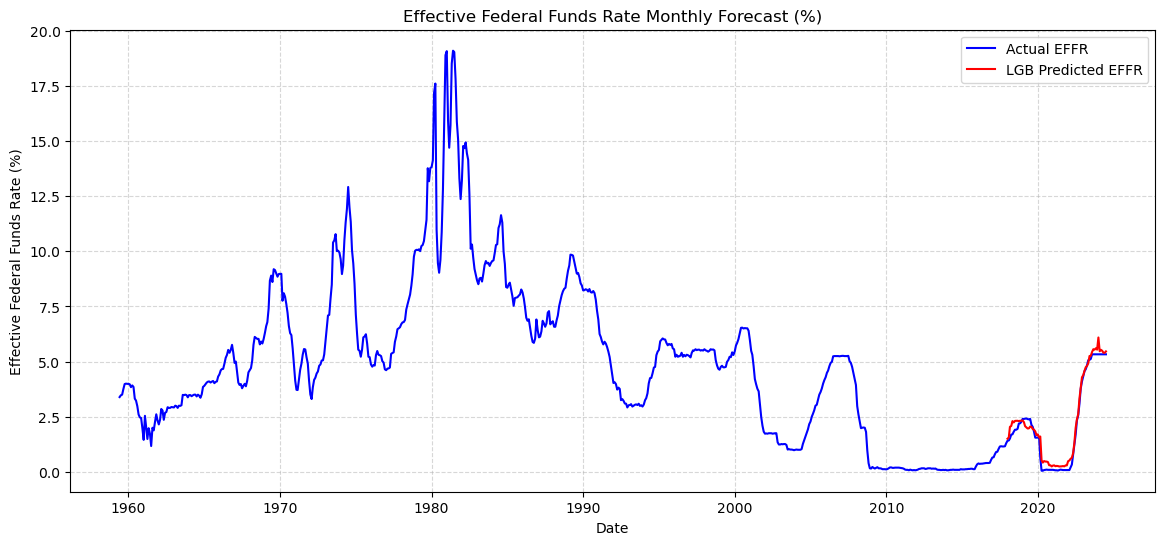

In [70]:
# Plot predictions against actual values
lagged_data['Predicted_FEDFUNDS'] = np.nan
lagged_data.loc[splits[1].index, 'Predicted_FEDFUNDS'] = predictions

plt.figure(figsize=(14, 6))
plt.plot(lagged_data['sasdate'], lagged_data['FEDFUNDS'], label='Actual EFFR', color='blue')
plt.plot(lagged_data['sasdate'], lagged_data['Predicted_FEDFUNDS'], label='LGB Predicted EFFR', color='red')
plt.title('Effective Federal Funds Rate Monthly Forecast (%)')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

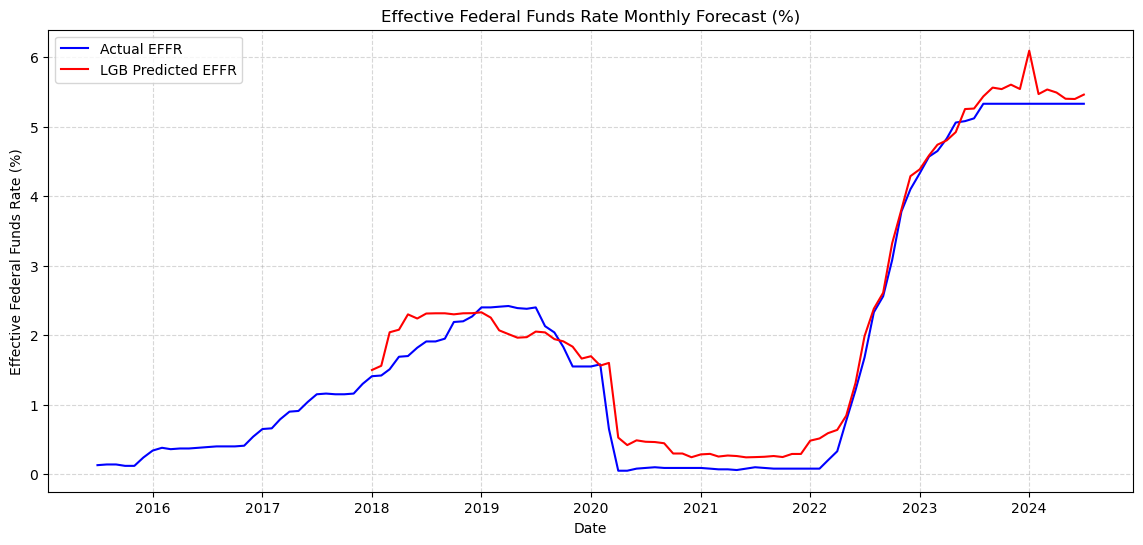

In [131]:
start_date = '2015-07-01'
# Filter the DataFrame to include only rows from the specified date onwards
filtered_data = lagged_data[lagged_data['sasdate'] >= start_date]
# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(filtered_data['sasdate'], filtered_data['FEDFUNDS'], label='Actual EFFR', color='blue')
plt.plot(filtered_data['sasdate'], filtered_data['Predicted_FEDFUNDS'], label='LGB Predicted EFFR', color='red')
plt.title('Effective Federal Funds Rate Monthly Forecast (%)')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The plot demonstrates that the LightGBM model captures the overall trend of the Effective Federal Funds Rate (EFFR) reasonably well, particularly during periods of steady increases and decreases. However, there are some noticeable deviations, especially during 2020 and the early 2024 spike, suggesting that while the model can track macroeconomic shifts, it may struggle to predict abrupt changes accurately. This highlights the need for further refinement or the inclusion of additional features to better anticipate such anomalies.

## Conclusion

In this work, we first introduced different methods for rate prediction, such as the linear model and the Taylor Rule. The latter has proven to be a good predictor for rates, but its main drawback lies in the fact that there have been many improvements to the 'classic' Taylor Rule. As shown in `Reevaluating the Taylor Rule with Machine Learning`, 2021 (9), it can be enhanced with machine learning (ML). The Federal Reserve (FED) itself has proposed several other indicators to adapt the Taylor Rule to the latest economic paradigms (`FED website for monetary policy` (5)) and states: "Fed policymakers consult, but do not mechanically follow, policy rules." Therefore, new methods must be adopted if we aim to create a time-invariant solution for rate predictions.

The second part of this work focuses on the implementation of a LightGBM model (and a Random Forest model in the corresponding notebook) using the monthly FRED database for rate predictions. While some variables are much more explanatory than others, the use of such models with restrictive hyperparameters allows us to compute fairly accurate estimations without overfitting. This model is able to outperform the Taylor Rule and the balanced approach during the period 2010-2018 (the test period for the model), though it does not surpass the most advanced criteria (Inertial and First Difference).

To go further, I would recommend developing a second text-based approach using NLP techniques to process the FED’s decision papers. One could also incorporate sentiment analysis from major market participants, for instance, by analyzing tweets. If interested, I have worked on a project scraping Twitter data using the API: `Binance_trade_automatization` (10).

## References and Sources

#### 1. Data Sources

`Github repository` : https://github.com/NicolasWalpoel/Machin-Learning-for-FED-Rates (1)

`FED website` : https://www.federalreserve.gov (2)

`FRED website` : https://fred.stlouisfed.org/ (3)

`Yahoo Finance website` : https://fr.finance.yahoo.com/ (4)

`CME FedWatch Tool` : https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html (8)

#### 2. Paper and research sources

`FED website for monetary policy` : https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm#fig1 (5)

`FFR Prediction` : https://github.com/chuayaocong/fed-funds-rate/blob/main (6)

`ISCTE Research Paper` : https://repositorio.iscte-iul.pt/bitstream/10071/30086/1/master_ana_ferreira_alao.pdf (7)

`Reevaluating the Taylor Rule with Machine Learning` :  https://arxiv.org/abs/2302.08323 (9)

`Binance_trade_autamatization` :  https://github.com/NicolasWalpoel/Binance_trade_autamatization (10)

